<a href="https://colab.research.google.com/github/Per-Y/Driven_Data-Pump_It_Up/blob/master/Pump_It_Up_Initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driven Data - Pump it Up
## Initial Submission Notebook

Latest Edit : *5-Sep-2020*

In this notebook, I have explained the process of making a first submission to the Driven Data Challenge '[Pump it Up](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/)'. This notebook will be followed up with a second notebook which will do hyperparameter optimization for the models used here and the results will be compared.

TBU:

1.   Background
2.   Exploratory Data Analysis




**Preprocessing of Data - Basics** 

In this section, some basic actions are taken :

1.   Import the dataset csv files as dataframes
2.   Combine the training and test data for preprocessing
3.   Assign Numerical Values to the 'Status Group' target category to suit training of models



In [19]:
# Importing Basic Libraries
import pandas as pd
import numpy as np

train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Pump It Up/Data Values_Train.csv')
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Pump It Up/Data Labels_Train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Pump It Up/Data Values_Test.csv')

# Combine train and test data
train_data['train'] = 1
test_data['train'] = 0
combined = pd.concat([train_data,test_data])

# assign numerical labels
label_dict_status_group = {'functional':0, 'non functional': 1, 'functional needs repair': 2}
train_labels.status_group = train_labels.status_group.replace(label_dict_status_group)


**Exploratory Data Analysis** - Python




In [20]:
"""
combined
#Checking Null Values
train_data.isnull().sum()
import reverse_geocoder as rg 
import pprint 
from pygeocoder import Geocoder
coordinates = (-3.821329,37.460664)
result = rg.search(coordinates)
pprint.pprint(result)

"""

'\ncombined\n#Checking Null Values\ntrain_data.isnull().sum()\nimport reverse_geocoder as rg \nimport pprint \nfrom pygeocoder import Geocoder\ncoordinates = (-3.821329,37.460664)\nresult = rg.search(coordinates)\npprint.pprint(result)\n\n'

**Exploratory Data Analysis** - Tableau


**Preprocessing of Data - Advanced**

In this section we do a few crucial actions :

1.   Remove the redundant features as identified in the previous section which includes
    *   Columns with several NaN values
    *   Columns with duplicate information
    *   Columns with a single value for all rows
    *   Columns with coordinates (other features act as a proxy for location information)
2.   Convert True/False boolean statements to integer type
3.   Perform one-hot encoding of categorical features (only top 25 most common values of each feature to be used)
4.   Merging Test Data with Labels




In [21]:
# Dropping Redundant Features (ie. columns with too many blanks, duplicate information, single value for all rows, coordinates)
combined = combined.drop(['source_type','date_recorded', 'source_class', 'waterpoint_type_group', 'longitude','latitude', 'quantity_group', 'num_private', 'subvillage', 'region','scheme_name','recorded_by','extraction_type'],axis=1)

# Converting Booleans to Integer Values
combined.permit = combined.permit.astype(bool).astype(int)
combined.public_meeting = combined.public_meeting.astype(bool).astype(int)

# List of columns to be one-hot encoded
cat_columns = ['funder', 'installer', 'wpt_name', 'basin', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'waterpoint_type']

# Selecting only the top 25 values per column for one-hot encoding
for col in cat_columns:
  # List of top 25 values for the feature 'col'
  top = [x for x in combined[col].value_counts().iloc[:25].index]
  for val in top:
    # Manual one-hot encoding for each value 'val' in the top 25 values
    combined[col + "_" + str(val)]=np.where(combined[col]==val,1,0)

# Dropping original columns after encoding
combined.drop(cat_columns, axis=1, inplace=True)

# Separating test and train data
train_data=combined[combined['train']==1]
test_data=combined[combined['train']==0]
train_data = train_data.drop(['train'],axis=1)
test_data = test_data.drop(['train'],axis=1)

# Merging labels with train data
train_data = pd.merge(train_data, train_labels, on = 'id')

In [22]:
# Cross checking if any Nulls remain
train_data.isnull().sum().sum()

0

**Modeling - Unoptimized**

Here we attempt to run a variety of standard classifiers on our dataset. First we shall import all the necessary libraries then proceed to use the following models :

1.   XGBoost Classifier
2.   Logistic Regression Classifier
3.   Support Vector Classifier
4.   Tensorflow Classifier



In [23]:
# Global libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

#Creating test-train split
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=['status_group','id']), train_data['status_group'],test_size=0.33, random_state=420)


**XGBoost Classifier**

In [24]:
from xgboost.sklearn import XGBClassifier

clf_xgb = XGBClassifier(objective='multi:softmax')

start_time = time.time()
clf_xgb.fit(X_train,y_train)

print("System took %s seconds to model" % (time.time() - start_time))
print(classification_report(y_test,clf_xgb.predict(X_test)))

System took 70.55963063240051 seconds to model
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     10659
           1       0.85      0.60      0.71      7498
           2       0.81      0.09      0.17      1445

    accuracy                           0.75     19602
   macro avg       0.79      0.55      0.56     19602
weighted avg       0.77      0.75      0.72     19602



**Logistic Regression Classifer**

In [25]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(solver='saga',max_iter=150)

start_time = time.time()
clf_lr.fit(X_train,y_train)

print("System took %s seconds to model" % (time.time() - start_time))
print(classification_report(y_test,clf_lr.predict(X_test)))

System took 40.588690757751465 seconds to model
              precision    recall  f1-score   support

           0       0.57      0.90      0.69     10659
           1       0.57      0.20      0.30      7498
           2       0.00      0.00      0.00      1445

    accuracy                           0.57     19602
   macro avg       0.38      0.37      0.33     19602
weighted avg       0.53      0.57      0.49     19602



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Support Vector Classifier**

In [26]:
from sklearn.svm import LinearSVC

clf_svm = LinearSVC()

start_time = time.time()
clf_svm.fit(X_train,y_train)

print("System took %s seconds to model" % (time.time() - start_time))
print(classification_report(y_test,clf_svm.predict(X_test)))

System took 28.31534218788147 seconds to model
              precision    recall  f1-score   support

           0       0.66      0.93      0.77     10659
           1       0.84      0.48      0.61      7498
           2       0.28      0.08      0.12      1445

    accuracy                           0.69     19602
   macro avg       0.59      0.50      0.50     19602
weighted avg       0.70      0.69      0.66     19602



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Note that we used LinearSVC since Multiclass SVC using one-versus-one solver takes too long due to its O(n*2) complexity. Due to this, our accuracy for the third class will always be zero.

**Artificial Neural Network Classifier / Multilayer Perceptron**

In [27]:
import sklearn.neural_network
clf_mlp = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)

start_time = time.time()
clf_mlp.fit(X_train,y_train)

print("System took %s seconds to model" % (time.time() - start_time))
print(classification_report(y_test,clf_mlp.predict(X_test)))

System took 27.898871183395386 seconds to model
              precision    recall  f1-score   support

           0       0.77      0.82      0.79     10659
           1       0.73      0.74      0.73      7498
           2       0.48      0.19      0.28      1445

    accuracy                           0.74     19602
   macro avg       0.66      0.59      0.60     19602
weighted avg       0.73      0.74      0.73     19602



**Results - Unoptimized**

We have XGBoost and MLP as our best performing models without any hyperparameter optimization. For references, we shall be running all of the models on the competition's test data and submit them to get a conclusive view of their effectiveness.

In [60]:
# Finding the predictions from the models on the final test data
xgb_pred = pd.DataFrame({'status_group' : clf_xgb.predict(test_data.drop(['id'],axis=1))})
lr_pred = pd.DataFrame({'status_group' : clf_lr.predict(test_data.drop(['id'],axis=1))})
svm_pred = pd.DataFrame({'status_group' : clf_svm.predict(test_data.drop(['id'],axis=1))})
mlp_pred = pd.DataFrame({'status_group' : clf_mlp.predict(test_data.drop(['id'],axis=1))})

# Adding the id column back to the predicitions
id_df = pd.DataFrame(test_data['id'])
xgb_pred = id_df.merge(xgb_pred,left_index=True,right_index=True)
lr_pred = id_df.merge(lr_pred,left_index=True,right_index=True)
svm_pred = id_df.merge(svm_pred,left_index=True,right_index=True)
mlp_pred = id_df.merge(mlp_pred,left_index=True,right_index=True)


# Creating Submission Files
label_dict_status_group = {0:'functional', 1:'non functional', 2:'functional needs repair'}
xgb_pred.status_group = xgb_pred.status_group.replace(label_dict_status_group)
lr_pred.status_group = lr_pred.status_group.replace(label_dict_status_group)
svm_pred.status_group = svm_pred.status_group.replace(label_dict_status_group)
mlp_pred.status_group = mlp_pred.status_group.replace(label_dict_status_group)

# Exporting the data to csv files for submission
pd.DataFrame(xgb_pred).to_csv('xgb_pred.csv',index=False)
pd.DataFrame(lr_pred).to_csv('lr_pred.csv',index=False)
pd.DataFrame(svm_pred).to_csv('svm_pred.csv',index=False)
pd.DataFrame(mlp_pred).to_csv('mlp_pred.csv',index=False)

We submitted the files to the portal and found that XGBoost performed the best followed by MLP and SVM. The scores are given below:

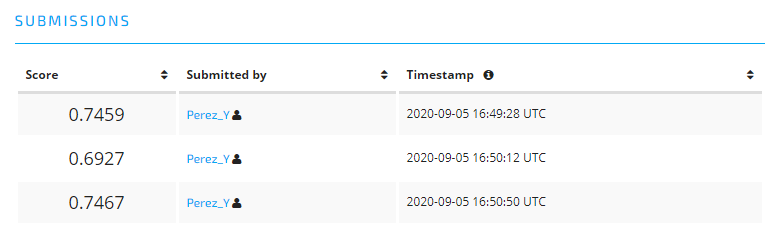

> XGB received 0.7467

> MLP Received 0.7459

> SVM received 0.6927

In the next notebook, we will optimize the parameters and discuss possible improvements to the project.